### Μεταφόρτωση αρχείων από το τοπικό σύστημα.

Με την βιβλιοθήκη <code>files</code> από το <code>google.colab</code> ανεβάζω τα απαραίτητα αρχεία για την υλοποίηση της άσκησης.

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dataset-HAR-PUC-Rio.csv to dataset-HAR-PUC-Rio.csv
User uploaded file "dataset-HAR-PUC-Rio.csv" with length 14283211 bytes


# Data Preprocessing
> **Γιατί κάνουμε data preprocessing**: Το data set μας πολύ πιθανών να αποτελείται απο features διαφορετικών range.Για παράδειγμα, το ένα feature μπορεί να είναι η ηλικία ενός ατόμου που κυμαίνεται στο διάστημα $[0,120]$, ενώ ένα άλλο feature μπορεί να αναφέρεται σε κάποιο χρηματικό ποσό που κυμαίνεται στο διάστημα $[0,100000]$.Αυτό έχει ως αποτέλεσμα το δεύτερο feature να επηρεάζει περισσότερο την έξοδο από το πρώτο.Επομένως προσθέτουμε ένα bias ως προς το δεύτερο χαρακτηριστικό.<br><br>
>**Normalization**: Με αυτή την μέθοδο μεταφέρουμε το εύρος κάθε feature στο διάστημα $[0,1]$.Έτσι επιλύουμε το παραπάνω πρόβλημα.Αυτή η μέθοδος χρησιμοποιείται σε αλγόριθμους που δεν κάνουν υποθέσεις για την κατανομή των δεδομένων , όπως τα **neural networks**.Για αυτό τον λόγο θα χρησιμοποιηθεί αυτή η τεχνική για το πρόβλημά μας.<br><br>
>**Standarization**: Αυτή η μέθοδος υποθέτει ότι τα δεδομένα ακολουθούν gaussian distribution μετασχηματίζοντας τα έτσι ώστε να έχουν μηδενική μέση τιμή και διασπορά ίση με 1.Χρησιμοποιείται λοιπόν σε αλγόριθμους που υποθέτουν ότι τα δεδομένα ακολουθούν gaussian distribution όπως το **linear regresion**.<br><br>
>**Centralization**: Αυτή η μέθοδος μετασχηματίζει τα δεδομένα έτσι ώστε να έχουν μηδενική μέση τιμή. Παρόλα αυτά δεν λύνει το πρόβλημα που αναφέρθηκε παραπάνω.

In [3]:
from pandas.tseries.offsets import YearBegin
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

                  ### read dataset ###
dataset = pd.read_csv("dataset-HAR-PUC-Rio.csv",delimiter=";", low_memory=False)



                  ### transform strings to integers ###
# create dictionary that maps strings to numbers
string_to_num = {'debora': 1, 'katia': 2, 'wallace': 3, 'jose_carlos': 4, 'Woman': 1, 'Man': 2 }

# lambda function. This function transforms string columns to int using the above dictionary
def map_strings_to_nums(col):
    return col.apply(lambda x: string_to_num[x] if x in string_to_num else x)

# apply lambda function to string columns
dataset[['user', 'gender', 'class']] = dataset[['user', 'gender', 'class']].apply(map_strings_to_nums)



                  ### One Hot Encode Output ###
# one hot encode output
labels = dataset['class'].values.reshape(-1, 1)
encoder = OneHotEncoder()
Y = pd.DataFrame(encoder.fit_transform(labels).toarray())



                  ### trasform data to float ###
# replace ',' with '.' so astype can work
dataset['how_tall_in_meters'] = dataset['how_tall_in_meters'].str.replace(',','.')
dataset['body_mass_index'] = dataset['body_mass_index'].str.replace(',','.')

# split features and Output
X = dataset.drop('class', axis=1)

# transform data to float
X = X.astype(float)
Y = Y.astype(float)
 


                  ### normalize data ###
#Normalize features
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


# Cross Validation

> **Γιατί;**: Αυτή η μέθοδος χρησιμοποιείται για να εξασφαλίσουμε ότι το score του αλγορίθμου μας δεν εξαρτάται από τον τρόπο που επιλέγουμε τα <code>train_set</code> και <code>test_set</code>.<br><br>
> **Πως**;: Χωρίζουμε το dataset σε Κ folds και χρησιμοποιούμε τα Κ-1 για <code>train_set</code> και το υπολοιπώμενο για <code>test_set</code> μέχρι και τα K folds να έχουν γίνει <code>test_set</code>.Στο πρόβλημα μας θα χρησιμοποιήσουμε 5-fold cross validation.

In [76]:
from sklearn.model_selection import StratifiedKFold

NumOfFolds = 5

kf = StratifiedKFold(n_splits=NumOfFolds, shuffle=True, random_state=39)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, labels)):
    print(f"Fold {fold+1} Train Index: {train_idx}")
    print(f"Fold {fold+1} Test Index: {test_idx}")

Fold 1 Train Index: [     0      1      2 ... 165628 165629 165631]
Fold 1 Test Index: [     6     10     14 ... 165618 165624 165630]
Fold 2 Train Index: [     1      2      3 ... 165629 165630 165631]
Fold 2 Test Index: [     0      7      9 ... 165600 165603 165627]
Fold 3 Train Index: [     0      2      3 ... 165629 165630 165631]
Fold 3 Test Index: [     1      4     12 ... 165621 165622 165626]
Fold 4 Train Index: [     0      1      2 ... 165629 165630 165631]
Fold 4 Test Index: [     3      5      8 ... 165615 165617 165620]
Fold 5 Train Index: [     0      1      3 ... 165626 165627 165630]
Fold 5 Test Index: [     2     11     20 ... 165628 165629 165631]


# Επιλογή Αρχιτεκτονικής

##Loss Function

> **Accuracy**: Η ακρίβεια είναι μία loss funtion η οποία χρησιμοποιείται συχνά σε classification problems. Μετράει το ποσοστό των σωστά ταξινομημένων παραδειγμάτων προς τον αριθμό όλων των παραδειγμάτων. Παρόλο που αποδίδει καλά σε binary classification problems, δεν προτιμάται σε προβλήματα που η έξοδος είναι συνεχής ή αναπαριστά πιθανότητα.<br><br>
> **MSE**: Η mean squared error loss function χρησιμοποιείται συνήθως σε regression problems. Ορίζεται ως:<br><br>
$MSE = (1/N) * ∑(y_t - y_p)^2$<br><br>
Όπου Ν είναι ο συνολικός αριθμός των παραδειγμάτων, $y_t$ είναι το actual value και το $y_p$ είναι το predicted value. Λόγω του τετραγώνου στον τύπο, το MSE τιμωρεί περισσότερο τα μεγάλα λάθη σε σχέση με τα μικρά και είναι πολύ ευαίσθητος στα outliers.<br><br>
>**Cross-entropy**: Η cross entropy loss function χρησιμοποιείται συνήθως σε multi-class classification problems όπου η έξοδος παριστάνει πιθανότητα.Μετράει την διαφορά των πιθανοτικών κατανομών της πρόβλεψης και της επιθυμητής εξόδου.Ο τύπος είναι ο εξής: <br><br>
$CE = -∑ y_t * log(y_p)$<br><br>
Όπου $y_t$ είναι η επιθυμητή probability distribution (συνήθως αναπαριστάται με one hot encoding) και το $y_p$ είναι η predicted probability distribution(συνήθως την παίρνουμε χρησιμοποιώντας την softmax function).

## Layers

> Το νευρωνικό δίκτυο αποτελείται από τρία επίπεδα. Την είσοδο, την έξοδο και ένα κρυφό επίπεδο.Η είσοδος αποτελείται από 18 features , επομένως 18 nodes στο επίπεδο εισόδου.Το πρόβλημα που λύνεται είναι ένα multi-class classification problem με 5 classes. Δεδομένου ότι χρησιμοποιείται one hot encoding για την κωδικοποίησει της εξόδους , θα χρειαστεί 5 nodes στο επίπεδο εξόδου.To κρυφό επίπεδο θα αφεθεί ελεύθερο για πειραματισμό.<br><br>

## Activation Function

>Για το hidden layer θα χρησιμοποιηθεί η ReLU η οποία είναι μηδέν για αρνητικές τιμές και γραμμική όπου αλλού.Για το επίπεδο εξόδου θα χρησιμοποιηθεί η softmax καθώς η έξοδος αναπαριστά πιθανότητες για τις οποίες το άθροισμά τους είναι ίσο με 1.



In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

In [15]:
#np.mean(history, axis=0)
def average(history,NumOfFolds): 
  avg_mse = []
  avg_accuracy = []
  avg_crossentropy = []

  temp_mse = 0
  temp_accuracy = 0
  temp_crossentropy = 0
  for j in range(epoch):
    temp_mse = 0
    temp_accuracy = 0
    temp_crossentropy = 0
    #For each epoch counts the average metrics out of the total folds
    for i in range(NumOfFolds):
      temp_mse += history[i].history['val_mean_squared_error'][j]/NumOfFolds
      temp_accuracy += history[i].history['val_categorical_accuracy'][j]/NumOfFolds
      temp_crossentropy += history[i].history['val_loss'][j]/NumOfFolds
    
    # adds average to array
    avg_mse.append(temp_mse)
    avg_accuracy.append(temp_accuracy)
    avg_crossentropy.append(temp_crossentropy)
  return [avg_mse,avg_accuracy,avg_crossentropy]

In [48]:
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, MeanSquaredError

epoch = 20
batch_size = 100

metrics = []
avg_metrics = []
history = []
avg_history = []

#number of input features
input_dim = 18

#number of nodes in hidden layer for each experiment
hidden_dim = [5,11,23] 

#number of output
output_dim = 5

for i in range(len(hidden_dim)):
  for train_idx, test_idx in kf.split(X,labels):
      # create a sequential model
      model = Sequential()
      # add a hidden layer with hidden_dim neurons and ReLU activation function
      model.add(Dense(hidden_dim[i], input_dim=input_dim, activation='relu'))
      # add an output layer with 5 neurons and softmax activation function
      model.add(Dense(output_dim, activation='softmax'))
      #compile the model
      model.compile(optimizer=Adam(learning_rate=0.001),
                    loss=CategoricalCrossentropy(), 
                    metrics=[CategoricalAccuracy(),
                             MeanSquaredError()
                             ]
                    )
      
      # split dataset into test set and train set
      X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
      y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]

      # keep track of history and metrics
      history.append(model.fit(X_train, y_train, epochs=epoch,batch_size=batch_size ,  validation_data=(X_test, y_test), verbose='none'))
      metrics.append(model.evaluate(X_test, y_test))
  avg_history.append(average(history,NumOfFolds))
  avg_metrics.append(np.mean(metrics, axis=0))

  #clear history 
  history = []
  metrics = []

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1036/1036 [==============================] - 2s 2ms/step - loss: 0.5314 - categorical_accuracy: 0.8081 - mean_squared_error: 0.0574
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1036/1036 [==============================] - 1s 1ms/step - loss: 0.4846 - categorical_accuracy: 0.8267 - mean_squared_error: 0.0525
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
1036/1036 [==============================] 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

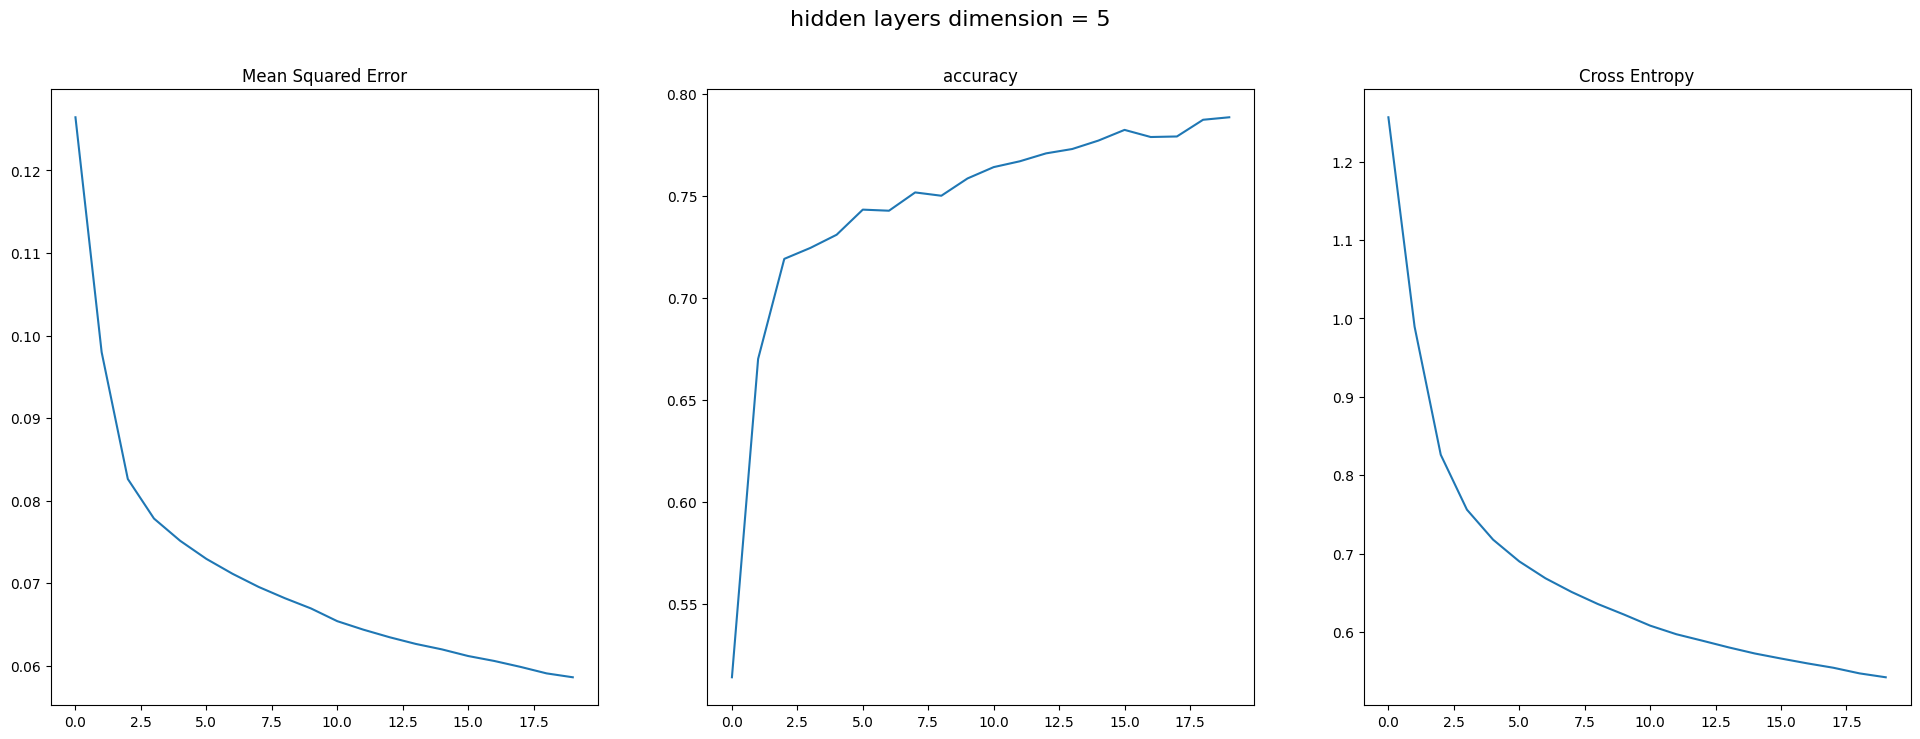

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

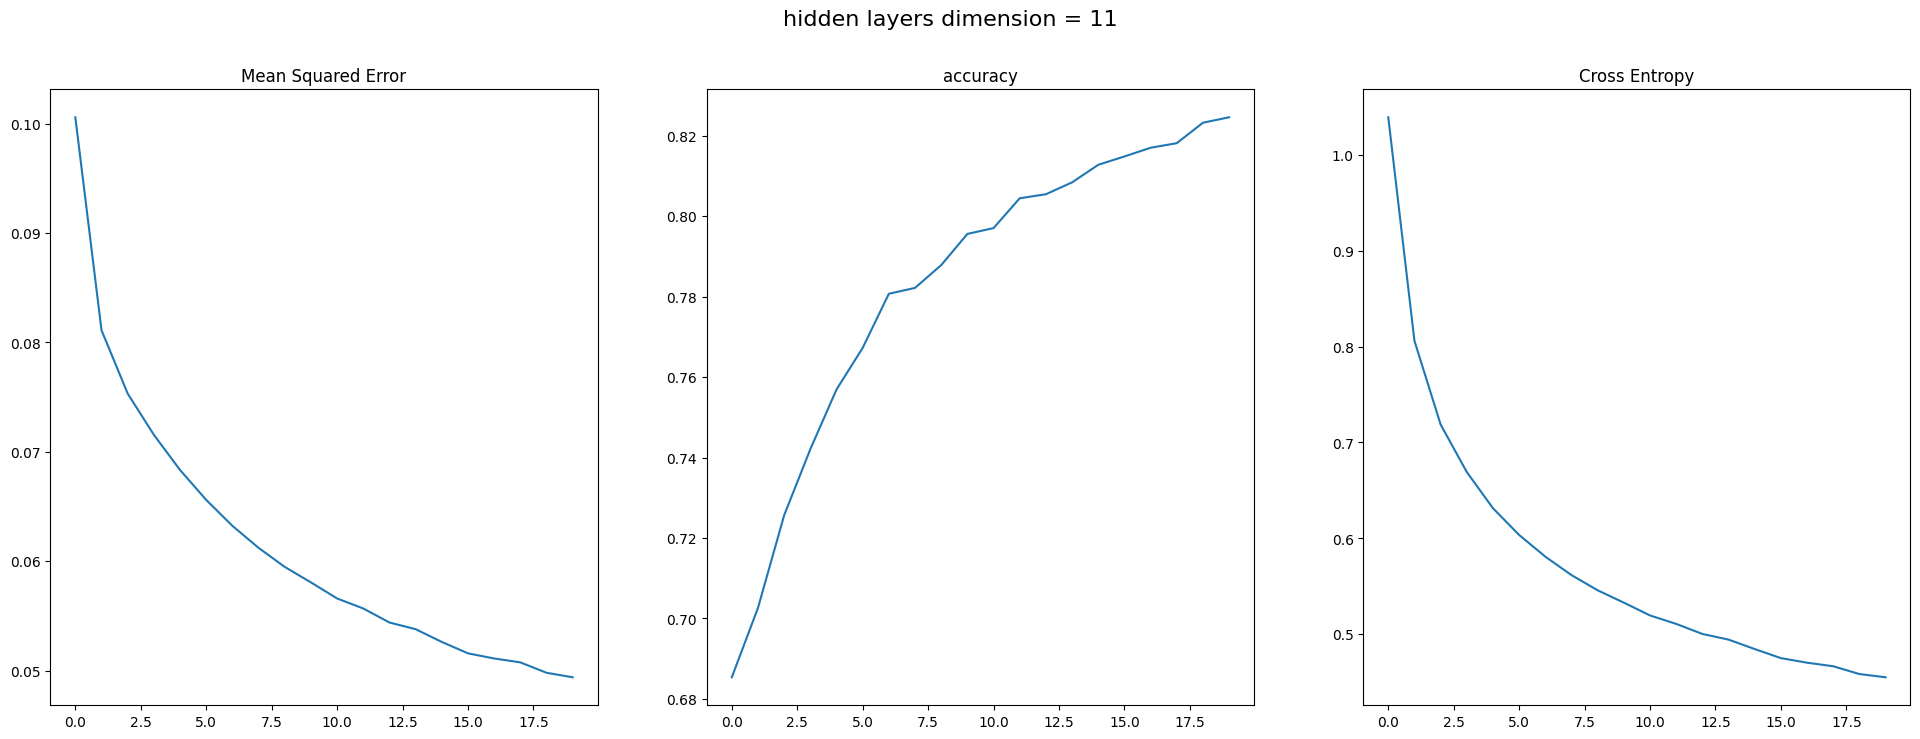

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

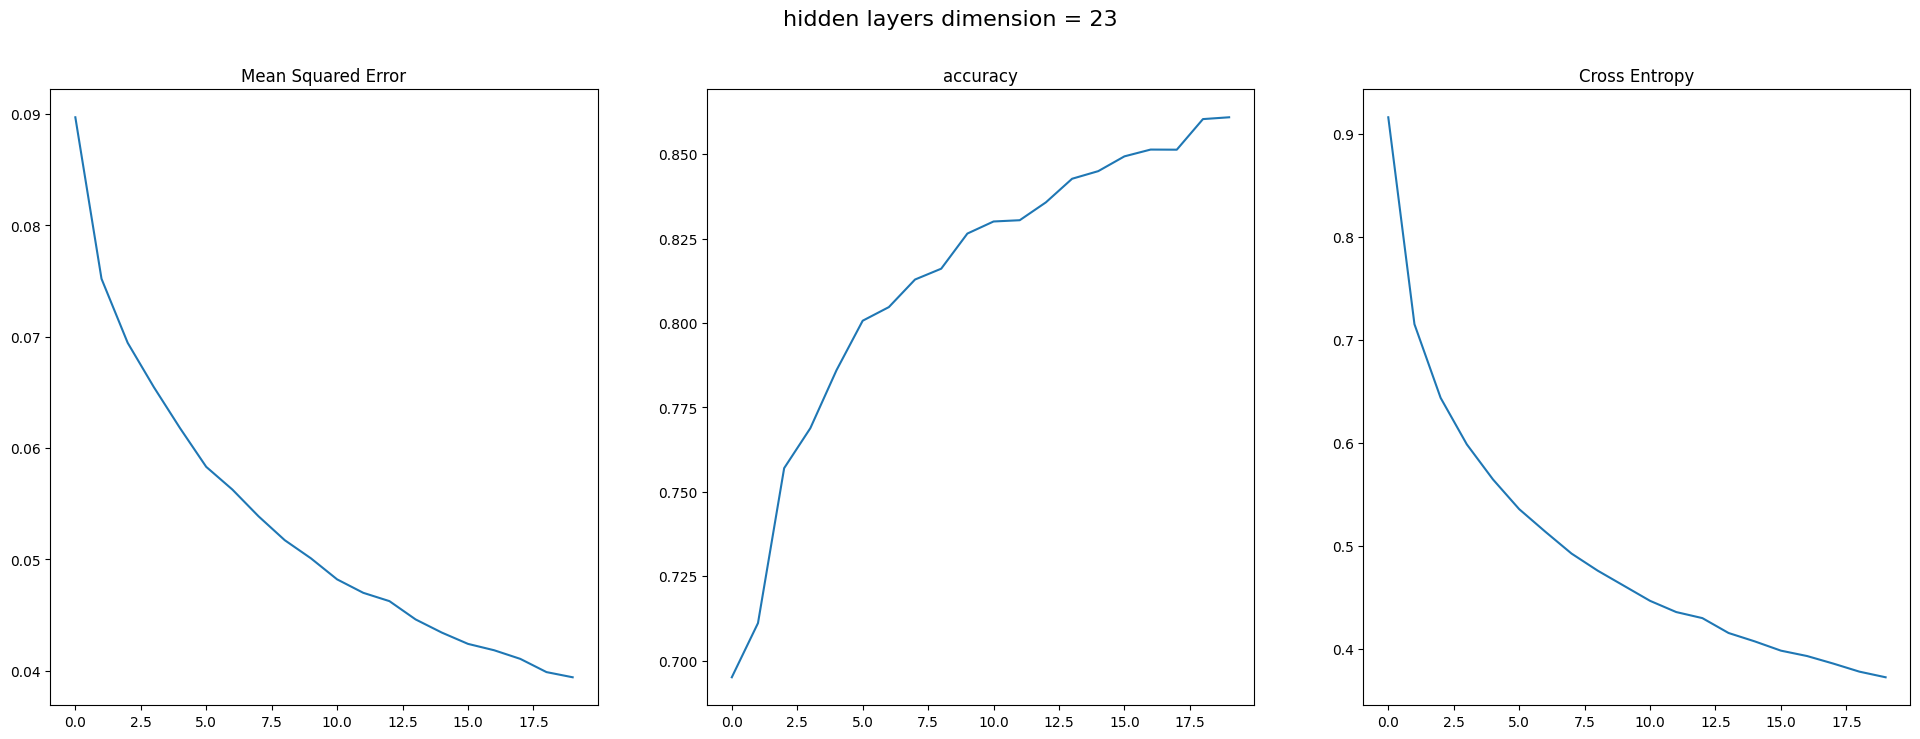

<IPython.core.display.Javascript object>

In [68]:
import matplotlib.pyplot as plt
from google.colab import widgets
from google.colab import output


tb = widgets.TabBar([str(i) for i in range(len(hidden_dim))])
for i in range(len(hidden_dim)):
  fig, axes = plt.subplots(nrows=1, ncols=len(hidden_dim), figsize=(24, 8))
  with tb.output_to(i, select=(i < len(hidden_dim))):  
    axes[0].plot(avg_history[i][0])
    axes[0].set_title('Mean Squared Error')

    axes[1].plot(avg_history[i][1])
    axes[1].set_title('accuracy')

    axes[2].plot(avg_history[i][2])
    axes[2].set_title('Cross Entropy')

    fig.suptitle('hidden layers dimension = '+str(hidden_dim[i]), fontsize=16)
    plt.show()

In [72]:
#print the average of metrics
print(f'For O nodes; Average loss: {avg_metrics[0][0]}, Average accuracy: {avg_metrics[0][1]}, Average MSE: {avg_metrics[0][2]}')
print(f'For (I+0)/2 nodes; Average loss: {avg_metrics[1][0]}, Average accuracy: {avg_metrics[1][1]}, Average MSE: {avg_metrics[1][2]}')
print(f'For I+O nodes; Average loss: {avg_metrics[2][0]}, Average accuracy: {avg_metrics[2][1]}, Average MSE: {avg_metrics[2][2]}')


For O nodes; Average loss: 0.542235404253006, Average accuracy: 0.7885610222816467, Average MSE: 0.05858534649014473
For (I+0)/2 nodes; Average loss: 0.45511515736579894, Average accuracy: 0.8245810508728028, Average MSE: 0.04938600957393646
For I+O nodes; Average loss: 0.37219961285591124, Average accuracy: 0.8609024882316589, Average MSE: 0.0393987238407135


<table>
  <tr>
    <th>hidden layer dimension</th>
    <th>CE LOSS</th>
    <th>MSE</th>
    <th>ACC</th>
  </tr>

  <tr>
    <td>H = O</td>
    <td>0.5422</td>
    <td>0.0586</td>
    <td>0.7885</td>
  </tr>

  <tr>
    <td>H = (I + O)/2</td>
    <td>0.4551</td>
    <td>0.0494</td>
    <td>0.8246</td>
  </tr>

  <tr>
    <td>H = I + O</td>
    <td>0.3722</td>
    <td>0.0394</td>
    <td>0.8609</td>
  </tr>
</table>

Παρατηρούμε μέσω των γραφημάτων και του πίνακα ότι όσο μεγαλώνει ο αριθμός των νευρώνων του κρυφού επιπέδου , τόσο μεγαλύτερο είναι το accuracy αλλά τόσο πιο αργά συγκλίνουμε στην λύση. Στο επόμενο κομμάτι της άσκησης θα χρησιμοποιήσω το μοντέλο με τους περισσότερους νευρώνες στο κρυφό επίπεδο.

## Early Stopping

Το early stopping είναι μια τεχνική που χρησιμοποιείται για την αποφυγή του overfitting. Με λίγα λόγια η μέθοδος αυτή σταματά την μάθηση μόλις η απόδοση του validation set αρχίζει και πέφτει. Επομένως θα μπορούσαμε κάλιστα να χρησιμοποιήσουμε αυτή την τεχνική στο παράδειγμά μας.

# Μεταβολές στον ρυθμό εκπαίδευσης και σταθεράς ορμής
